# GNN HW1

## 2) Higher-Dimensional Data

In [1]:
import sklearn
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from density_forest import DensityForest

In [17]:
digits = sklearn.datasets.load_digits()
X = digits.data
y = digits.target

X = X/16 #normalize

X_train, X_test, y_train, y_test = train_test_split(X, y)

models = {
    "Single Gaussian": GaussianMixture(n_components = 1),
    "GMM": GaussianMixture(n_components = 10),
    "KDE": KernelDensity(bandwidth = 2.0),
    "Density Forest": DensityForest(n_trees = 30, n_min = 5)
}

In [18]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train)

Training Single Gaussian...
Training GMM...
Training KDE...
Training Density Forest...


In [19]:
def squared_exponential_kernel (X, Y, h = 0.1):
    X_norm = np.sum(X**2, axis = 1, keepdims = True)
    Y_norm = np.sum(Y**2, axis = 1, keepdims = True).T
    dist = X_norm + Y_norm - 2 * X @ Y.T
    return np.exp(-dist/(2*(h**2)))

def inverse_multiquadratic_kernel(X,Y, h = 0.1):
    X_norm = np.sum(X**2, axis = 1, keepdims = True)
    Y_norm = np.sum(Y**2, axis = 1, keepdims = True).T
    dist = X_norm + Y_norm - 2* X @ Y.T
    return 1.0 / (1.0 + dist/(h**2))

def mmd2(X, Y, kernel_fn, h):
    XX = kernel_fn(X,X, h)
    YY = kernel_fn(Y,Y,h)
    XY = kernel_fn(X,Y,h)
    x = X.shape[0]
    y = Y.shape[0]
    mmd2 = XX.sum()/(x*x) + YY.sum()/(y*y) - 2*XY.sum()/(x*y)
    return mmd2

In [22]:
#Evaluate Models
for name, model in models.items():
    x_len = len(X_test)
    X_generated = model.sample(x_len)
    if isinstance(X_generated,tuple):
        X_generated = model.sample(x_len)[0]
    else:
        X_generated
        
    if hasattr(model, "score_samples"):
        scores = model.score_samples(X_test)
        if np.mean(scores)<0:
            dens_test = np.exp(scores)
        else:
            dens_test = scores
            mean_dens_test = np.mean(dens_test)
        mean_dens_test = np.mean(dens_test)
    else:
        mean_dens_test = np.nan

    mmd2_sek = mmd2(X_generated, X_test, squared_exponential_kernel, 1.0)
    mmd2_imk = mmd2(X_generated, X_test, inverse_multiquadratic_kernel, 1.0)

    print(f"{name}:")
    print(f"Mean Test Density: {mean_dens_test:.4f}")
    print(f"MMD^2 Squared Exponential Kernel: {mmd2_sek:.4f}\nMMD^2 Inverse Multiquadratic Kernel: {mmd2_imk:.4f}")
    print("_____________________________________")

Single Gaussian:
Mean Test Density: 69.0596
MMD^2 Squared Exponential Kernel: 0.0110
MMD^2 Inverse Multiquadratic Kernel: 0.0074
_____________________________________
GMM:
Mean Test Density: 99.9445
MMD^2 Squared Exponential Kernel: 0.0066
MMD^2 Inverse Multiquadratic Kernel: 0.0053
_____________________________________
KDE:
Mean Test Density: 0.0000
MMD^2 Squared Exponential Kernel: 0.0315
MMD^2 Inverse Multiquadratic Kernel: 0.1059
_____________________________________
Density Forest:
Mean Test Density: nan
MMD^2 Squared Exponential Kernel: 0.0066
MMD^2 Inverse Multiquadratic Kernel: 0.0056
_____________________________________


### Comments
1. Single Gaussian's mean test density is pretty high which shows it has a good likelihood for the test data. It also has low MMD^2 values which implies that the generated samples are close to the test data.
2. GMM has the highest mean test density which means it has the best likelihood out of all the models for the test data. It's MMD^2 scores are the lowest which implies that the generated samples were most similar to the test data.
3. KDE has either a zero mean test density or a very close to zero mean test density. The MMD^2 values are also higher than the other models. Both of these imply that there is a great discrepancy between the KDE sample data and the test data.
4. Density Forest doesn't have a mean test density since it doesn't have a scored_samples attribute. It's low MMD^2 scores show that the generated samples are close to the test data.

Random Forest Classifier
Train Accuracy: 1.0000, Test Accuracy: 0.9733
Single Gaussian


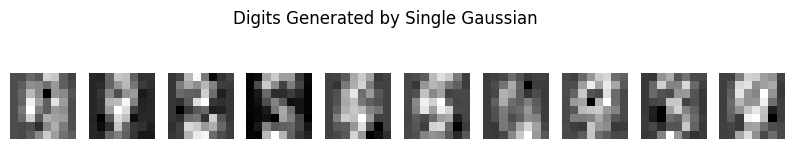

GMM


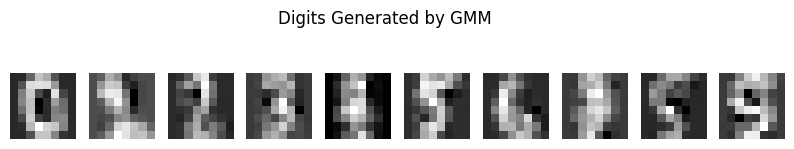

KDE


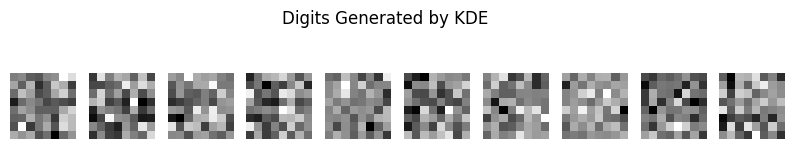

Density Forest


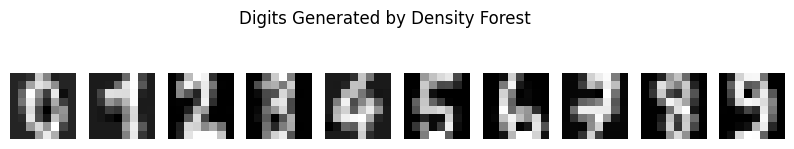

In [26]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print(f"Random Forest Classifier\nTrain Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

for name, model in models.items():
    X_sample = model.sample(1000)
    if isinstance(X_sample, tuple):
        X_generated = X_sample[0] 
    else:
        X_generated = X_sample
    preds = rf.predict(X_generated)

    print(f"{name}")
    fig, axes = plt.subplots(1, 10, figsize = (10,2))

    for i in range(10):
        if np.any(preds == i):
            axes[i].imshow(X_generated[preds == i][0].reshape(8,8), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Digits Generated by {name}")
    plt.show()


### Comments
1. Single Gaussian has some noise but it is still possible to barely make out the shape of the digit.
2. GMM is a little less noisy than single gaussian and it is a bit easier to see the shape of the digits.
3. KDE has a lot of noise and it is impossible to determine what digits are present.
4. Density Forest has minimal noise and it is very easy to see the shapes of the digits.